# Summary



Explore the angular properties of the geomorphic Hamilton and its associated metric tensor.

### Parameter files

In [1]:
# Specify the parameter files for the job
import os
if 'GME_NB_PR' not in os.environ.keys():
    pr_filenames = ['MetricSpace_sinbeta_eta1p5']
#     pr_filenames = ['MetricSpace_sinbeta_eta0p5']
#     pr_filenames = ['MetricSpace_sinbeta_eta0p33']
#     pr_filenames = ['MetricSpace_sinbeta_eta0p25']
else:
    pr_filenames = eval(os.environ['GME_NB_PR'])

### Logging

In [2]:
from importlib import reload
import logging, sys
# reload(logging)
logging.basicConfig(level=logging.INFO, format=f'%(message)s')

### Modules

In [138]:
# Import Numpy
import numpy as np

# Import SymPy and set up latex inline & pretty dict printing
from sympy import Matrix, Eq, lambdify, poly, numer, denom, \
    simplify, factor, expand, cancel, collect, expand_trig, \
    sin,cos,tan,sec, atan, Rational, sqrt, solve, Abs, N, re, im, det, \
    sign, Piecewise, diff, init_printing, plot, pi, deg
# Set up latex inline printing
init_printing(pretty_print=True,wrap_line=True)

# Import units & dimensions
from sympy.physics.units import degrees
from sympy.physics.units.systems import SI

# Pretty dict printing etc
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4).pprint
from datetime import datetime

# Import Geomorphysics library functions, classes
from gmplib.utils import numify, export_results, e2d
from gmplib.save import create_directories, export_plots
from gmplib.parameters import import_parameters, Parameters
from gmplib.plot_utils import GraphingBase

# Import GME classes and do a wildcard (!) import of all GME symbol definitions
from gme.core.symbols import *
from gme.core.equations import Equations
from gme.plot.alphabeta import AlphaBeta

# Decide where we're working and thus where to find the job parameter files
#   -  use the GME_WORKING_PATH environment variable if it's defined
#   -  otherwise, deduce that we're working in the gme notebook dir
if 'GME_WORKING_PATH' in os.environ.keys():
    working_path = os.environ['GME_WORKING_PATH']
    print(f'Fetching working path from environment variable GME_WORKING_PATH = {working_path}')
else:
    from gmplib.utils import get_pkg_path
    import gme
    working_path = get_pkg_path(gme, dirname='')
    print(f'Deducing working path from gme package location = {working_path}')
    del gme
    
# Set the path to the parameter files for this nb and report
pr_path = os.path.join(working_path,'Parameters','Theory')
pr_path, pr_filenames

Deducing working path from gme package location = /Users/colinstark/Projects/GME


('/Users/colinstark/Projects/GME/Parameters/Theory',
 ['MetricSpace_sinbeta_eta1p5'])

In [4]:
import matplotlib as mpl, matplotlib.pyplot as plt
mpl.rc('font', size=14, family='Arial')

# Theory

## Basics

In [5]:
parameters_dict,_ = import_parameters([pr_path], [os.path.join('..','defaults'), 
                                                  *pr_filenames])
evaluations = {}
evaluations_sequence = ()
pr = Parameters(parameters_dict, evaluations=evaluations, sequence=evaluations_sequence)
[pp(psubobj.__dict__) for psubobj in (pr.job,pr.model,pr.solve,pr.resolve,pr.plot,pr.save)];

{   'debug': False,
    'group_name': 'Theory',
    'short_name': 'metricspace',
    'subtitle': '',
    'title': 'Exploration of metric space for sin(beta) erosion model, eta=3/2',
    'verbose': True,
    'very_verbose': False}
{   'Ci': pi/45,
    'Lc': 10000,
    'beta_type': 'sin',
    'do_geodesic': False,
    'eta': 3/2,
    'h_0': 1/2,
    'ibc_type': 'concave-up',
    'kappa_h': 3/2,
    'mu': 3/4,
    't_xiv0_list': None,
    'varepsilonhat': 1/100,
    'varphi_0': 20,
    'varphi_type': 'ramp',
    'x_h': 1,
    'x_sigma': 0.01,
    'xiv_0': 30}
{   'choice': 'Hamilton',
    'do_dense': True,
    'do_geodesic': True,
    'do_ic': False,
    'do_ip': False,
    'do_vb': False,
    'ic_res': 31,
    'ip_res': 101,
    'method': {   'Hamilton': 'DOP853',
                  'choices': ['RK45', 'RK23', 'Radau', 'DOP853', 'LSODA'],
                  'geodesic': 'LSODA'},
    'ray_n_t': 301,
    't_distribn': 2,
    't_end': 0.01,
    'vb_res': 101}
{   'do_eliminate_caustics': True

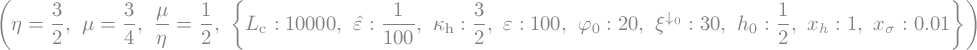

In [6]:
sub = {
        Lc: pr.model.Lc, 
        varepsilonhat: pr.model.varepsilonhat, 
        varepsilon: pr.model.varepsilonhat*pr.model.Lc, 
        varphi_0: pr.model.varphi_0,
        xiv_0: pr.model.xiv_0,
        kappa_h: pr.model.kappa_h,
        h_0: pr.model.h_0,
        x_sigma: pr.model.x_sigma,
        x_h: pr.model.x_h
}
Eq(eta,pr.model.eta), Eq(mu,pr.model.mu), Eq(mu/eta,pr.model.mu/pr.model.eta), sub

In [7]:
def eqns(eqn_list):
    return [getattr(gmeq, eqn) for eqn in eqn_list]

In [8]:
raw_gmeq = Equations( do_raw=True,
                      eta_=pr.model.eta, 
                      mu_=pr.model.mu, 
                      beta_type=pr.model.beta_type, 
                      varphi_type=pr.model.varphi_type, 
                      ibc_type=pr.model.ibc_type,
                      do_idtx=False,
                      do_geodesic=False, 
                      parameters=sub )

In [9]:
gmeq = Equations( do_raw=False,
                  eta_=pr.model.eta, 
                  mu_=pr.model.mu, 
                  beta_type=pr.model.beta_type, 
                  varphi_type=pr.model.varphi_type, 
                  ibc_type=pr.model.ibc_type,
                  do_idtx=False,
                  do_geodesic=False, 
                  parameters=sub )

In [10]:
prefix = ('_').join([pr.job.short_name, gmeq.beta_type+'beta', 
                     gmeq.varphi_type.replace('-','')])
suffix = f'_eta{ float(sy.N(gmeq.eta_)):0.2f}' if gmeq.eta_==Rational(1,3) \
                                    else f'_eta{ float(N(gmeq.eta_)):0.1f}'
suffix += f'_ratio{ float(sy.N(gmeq.mu_/gmeq.eta_)):0.2f}' \
                    if gmeq.mu_/gmeq.eta_==Rational(1,3) \
                    else f'_ratio{ float(N(gmeq.mu_/gmeq.eta_)):0.1f}'
suffix = (suffix if pr.model.varphi_type=='ramp' \
            else suffix+f'_xh{float(gmes.parameters[x_h]):1.1f}').replace('.','p')

job_name = prefix+suffix
job_name

'metricspace_sinbeta_ramp_eta1p5_ratio0p5'

## Angles

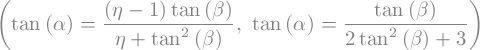

In [11]:
raw_gmeq.tanalpha_beta_eqn, gmeq.tanalpha_beta_eqn

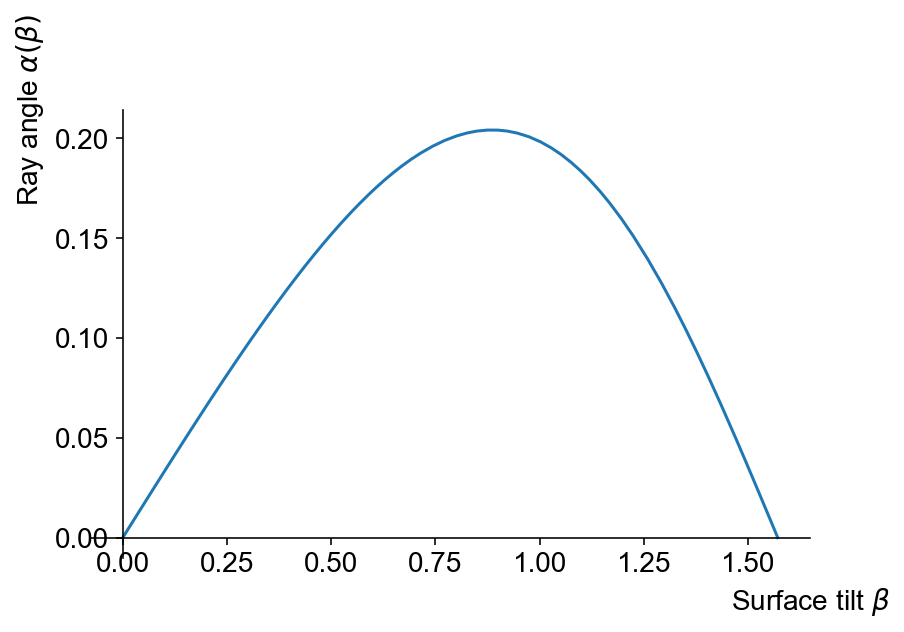

In [12]:
plot(gmeq.tanalpha_beta_eqn.rhs, (beta,0,pi/2), 
        xlabel=r'Surface tilt $\beta$', ylabel=r'Ray angle $\alpha(\beta)$');

In [13]:
raw_gmeq.define_tanbeta_eqns(), gmeq.define_tanbeta_eqns()

(None, None)

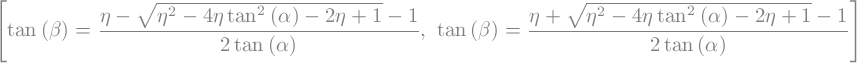

In [14]:
raw_gmeq.tanbeta_alpha_eqns

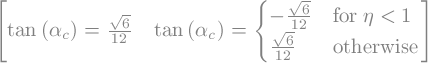

In [15]:
Matrix([raw_gmeq.tanalpha_crit_eqn.subs({eta:pr.model.eta}), gmeq.tanalpha_crit_eqn]).T

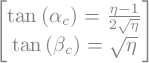

In [16]:
Matrix([raw_gmeq.tanalpha_crit_eqn, raw_gmeq.tanbeta_crit_eqn])

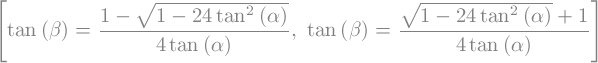

In [17]:
gmeq.tanbeta_alpha_eqns

In [18]:
switch = symbols(r'\text{switch}',  real=True, positive=True)
# tanbeta_tanalpha_piecewise = Piecewise( 
#                                         (gmeq.tanbeta_alpha_eqns[0].rhs, switch<1),
#                                         (gmeq.tanbeta_alpha_eqns[1].rhs, True) 
#                                     )
# tanbeta_tanalpha_lambda = lambdify( (tan(alpha),switch), 
#                                    tanbeta_tanalpha_piecewise, 
#                                    modules='sympy')
# tanbeta_tanalpha_piecewise

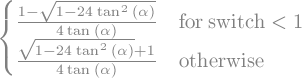

In [19]:
tanbeta_tanalpha_piecewise = Piecewise( 
    (gmeq.tanbeta_alpha_eqns[0].rhs, switch<1),
    (gmeq.tanbeta_alpha_eqns[1].rhs, True) )

tanbeta_tanalpha_lambda = lambdify( (tan(alpha),switch), tanbeta_tanalpha_piecewise, modules='sympy')
tanbeta_tanalpha_piecewise

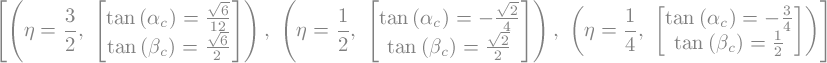

In [20]:
[(Eq(eta,eta_),Matrix([(raw_gmeq.tanalpha_crit_eqns[0] if eta_<1 else raw_gmeq.tanalpha_crit_eqns[1]).subs({eta:eta_}), 
                       (raw_gmeq.tanbeta_crit_eqns[0]  if eta_<1 else raw_gmeq.tanbeta_crit_eqns[1]).subs({eta:eta_})]) )
 for eta_ in [Rational(3,2),Rational(1,2),Rational(1,4)]]

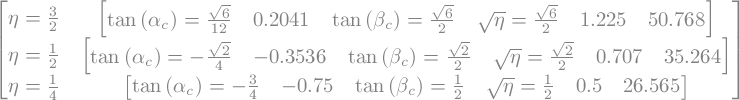

In [21]:
Matrix([(
    Eq(eta,eta_),
    Matrix([
    ([ Matrix([Eq(tan(alpha_crit),soln.subs({eta:eta_})), round(N(soln.subs({eta:eta_})),4)]).T,
        Matrix([
        raw_gmeq.tanbeta_alpha_eqns[0].subs({beta:beta_crit, eta:eta_, 
                                             tan(alpha):soln.subs({eta:eta_})}),
        Eq(sqrt(eta),sqrt(eta_)),
        round(raw_gmeq.tanbeta_alpha_eqns[0].rhs.subs({eta:eta_, tan(alpha):soln.subs({eta:eta_})*1}),3),
        np.round(np.rad2deg(float(N(atan(raw_gmeq.tanbeta_alpha_eqns[0].rhs
                                         .subs({eta:eta_, tan(alpha):soln.subs({eta:eta_})*1}))))),3),
        ]).T
        ]) for soln in [raw_gmeq.tanalpha_crit_eqns[1].rhs 
                        if eta_==Rational(3,2) else raw_gmeq.tanalpha_crit_eqns[0].rhs] ])
) for eta_ in [Rational(3,2),Rational(1,2),Rational(1,4)] ])

In [22]:
# tanalpha_lambda = lambdify( (beta), gmeq.tanalpha_beta_eqn.rhs, modules='sympy' )
# tanbeta_alpha_eqns = [Eq(tan(beta), soln.subs({ta:tan(alpha)}))
#                          for soln in (sy.solve(gmeq.tanalpha_beta_eqn.subs({tan(alpha):ta}),tan(beta)))]
# tanbeta_alpha_eqns

## Metric tensors

In [23]:
unitvec = lambda alpha: N(Matrix([cos(alpha),sin(alpha)]).T)
get_eigenvalues = lambda evs: [ev[0] for ev in evs]
get_eigenvectors = lambda evs: [ev[2][0] for ev in evs]
get_eigentanangles = lambda evs: [ev[2][0][1]/ev[2][0][0] for ev in evs]

In [24]:
raw_gmeq.p_covec_eqn.rhs

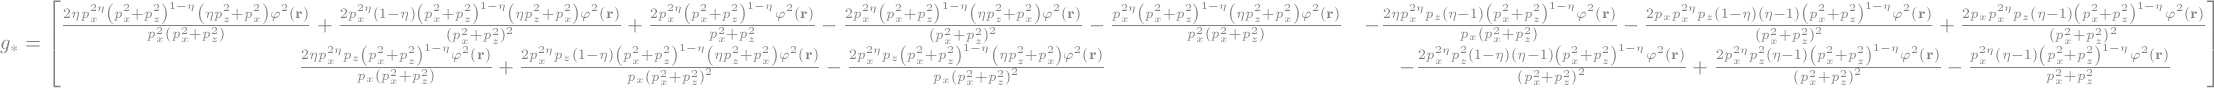

In [25]:
gstar_varphi_pxpz_eqn = Eq(gstar,
    factor( Matrix([diff(raw_gmeq.rdot_vec_eqn.rhs, raw_gmeq.p_covec_eqn.rhs[0]).T,
                    diff(raw_gmeq.rdot_vec_eqn.rhs, raw_gmeq.p_covec_eqn.rhs[1]).T]) ))
gstar_varphi_pxpz_eqn.subs({varphi_r:varphi})

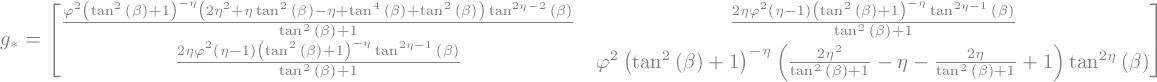

In [26]:
gstar_tanbeta_eqn = (expand_trig(simplify( 
        gstar_varphi_pxpz_eqn
            .subs({varphi_r(rvec):varphi})
            .subs(e2d(raw_gmeq.px_pz_tanbeta_eqn))
    )).subs({Abs(cos(beta)):cos(beta)})
    .subs({sin(beta):sqrt(1-cos(beta)**2)})
    .subs({cos(beta):1/sqrt(1+tan(beta)**2)}) )
gstar_tanbeta_eqn

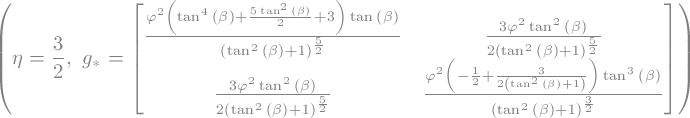

In [27]:
gstar_tanbeta_lambda = lambdify( (tan(beta),varphi), 
                                gstar_tanbeta_eqn.rhs.subs({eta:pr.model.eta}), 
                                modules='sympy')
Eq(eta,pr.model.eta), gstar_tanbeta_eqn.subs({eta:pr.model.eta})

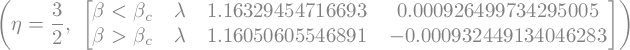

In [28]:
eta_ = Rational(3,2)
gstar_tanbeta_eta1p5_lambda = lambdify( (tan(beta),varphi), 
                                gstar_tanbeta_eqn.rhs.subs({eta:eta_}), 
                                modules='sympy')
Eq(eta,eta_), Matrix(
    [[beta<beta_crit, lmbda]+list((gstar_tanbeta_eta1p5_lambda(sqrt(eta_*0.99),1)
                            .n().eigenvals()).keys()),
     [beta>beta_crit, lmbda]+list((gstar_tanbeta_eta1p5_lambda(sqrt(eta_*1.01),1)
                  .n().eigenvals()).keys())])

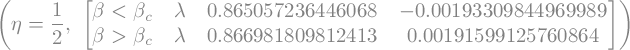

In [29]:
eta_ = Rational(1,2)
gstar_tanbeta_eta0p5_lambda = lambdify( (tan(beta),varphi), 
                                gstar_tanbeta_eqn.rhs.subs({eta:eta_}), 
                                modules='sympy')
Eq(eta,eta_), Matrix(
    [[beta<beta_crit, lmbda]+list((gstar_tanbeta_eta0p5_lambda(sqrt(eta_*0.99),1)
                            .n().eigenvals()).keys()),
     [beta>beta_crit, lmbda]+list((gstar_tanbeta_eta0p5_lambda(sqrt(eta_*1.01),1)
                  .n().eigenvals()).keys())])

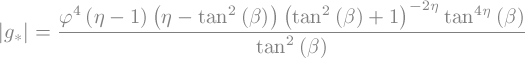

In [30]:
Eq(det(gstar),factor( (gstar_tanbeta_eqn.rhs).det() ))

In [31]:
Eq(tan(beta_crit),solve(Eq(factor(gstar_tanbeta_eqn.rhs.det()),0),tan(beta))[1])

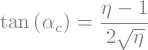

In [32]:
Eq(tan(alpha_crit), solve(raw_gmeq.tanbeta_alpha_eqns[0].subs({tan(beta):sqrt(eta)}),tan(alpha))[0])

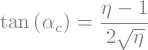

In [33]:
raw_gmeq.tanalpha_crit_eqn

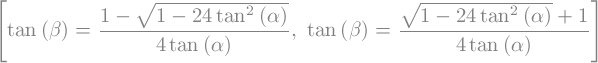

In [34]:
gmeq.tanbeta_alpha_eqns

In [35]:
tanalpha_tanbeta_lambda = lambdify( (tan(beta)), gmeq.tanalpha_beta_eqn.rhs, modules='sympy')

In [36]:
g_tanbeta_eqn = (simplify(factor( gmeq.g_varphi_pxpz_eqn
        .subs({varphi_r(rvec):varphi})
        .subs(e2d(gmeq.px_pz_tanbeta_eqn)) ))
        .subs({Abs(cos(beta)):cos(beta)})
        .subs({cos(beta):1/sqrt(1+tan(beta)**2)}) )
g_tanalpha_eqns = [Eq( g, factor(expand_trig(g_tanbeta_eqn.rhs))
                        .subs({cos(beta):1/sqrt(1+tan(beta)**2)})
                        .subs(e2d(tanbeta_alpha_eqn)) )
                  for tanbeta_alpha_eqn in gmeq.tanbeta_alpha_eqns]
# Matrix(g_tanalpha_eqns)

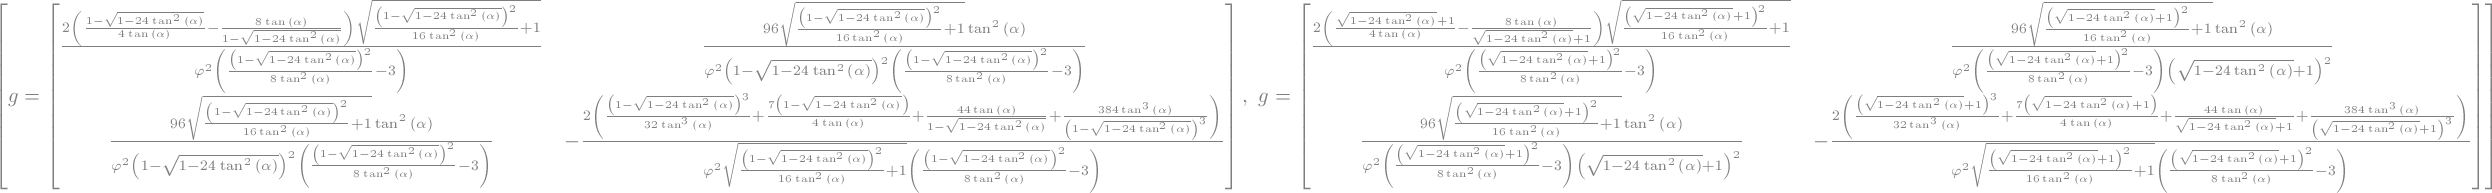

In [37]:
g_tanalpha_eqns

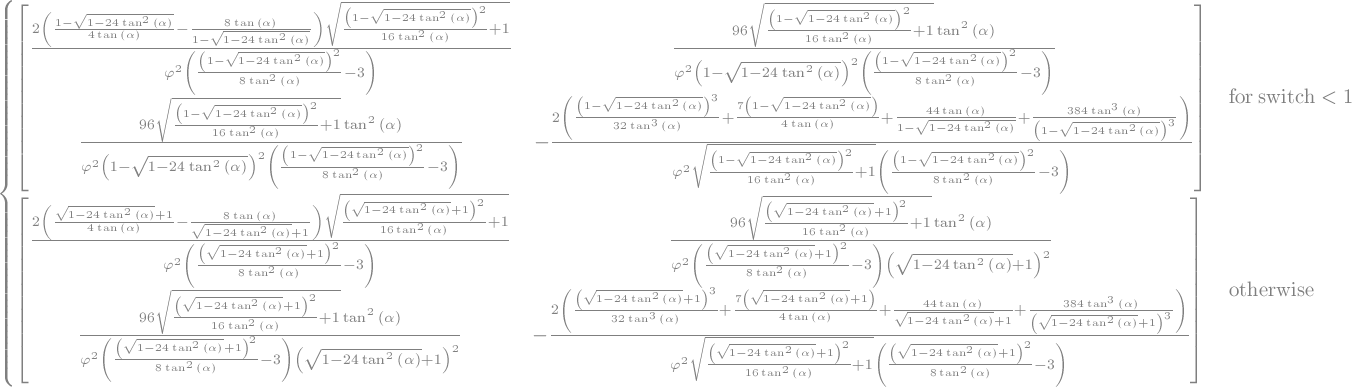

In [38]:
# if gmeq.eta>1:
g_tanalpha_piecewise = Piecewise( 
    (g_tanalpha_eqns[0].rhs, switch<1),
    (g_tanalpha_eqns[1].rhs, True) 
)
# else:
#     g_tanalpha_piecewise = Piecewise( 
#         (g_tanalpha_eqns[0].rhs, switch<1),
#         (g_tanalpha_eqns[1].rhs, True) 
#     )
g_tanalpha_lambda = lambdify( (tan(alpha),varphi,switch), 
                             g_tanalpha_piecewise, modules='sympy')
g_tanalpha_piecewise

## Coordinates

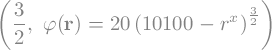

In [39]:
gmeq.eta_, gmeq.varphi_rx_eqn.subs(sub).subs({mu:pr.model.mu})

In [40]:
tanalpha_crit_ = N(gmeq.tanalpha_crit_eqn.rhs.subs({eta:gmeq.eta_}))
tanalpha_ = tanalpha_crit_*0.9
tanbeta_ = tanbeta_tanalpha_lambda(tanalpha_,0.5)
tanbeta_crit_ = round(tanbeta_tanalpha_lambda(tanalpha_crit_,1),5)
tanalpha_crit_, tanalpha_, tanbeta_crit_, tanbeta_

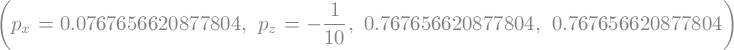

In [41]:
pz_ = (gmeq.pz0_xiv0_eqn.rhs.subs({xiv_0:10}))
px_ = gmeq.px_pz_tanbeta_eqn.rhs.subs({pz:pz_,tan(beta):tanbeta_})
Eq(px,px_), Eq(pz,pz_), -px_/pz_, tanbeta_

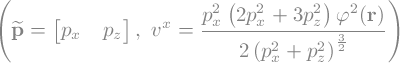

In [42]:
gmeq.p_covec_eqn, gmeq.rdotx_pxpz_eqn

In [43]:
gmeq.p_covec_eqn.rhs

In [44]:
pcovec_lambda = lambdify( (px,pz), 
                          gmeq.p_covec_eqn.rhs,
                          modules='sympy' )
pcovec_ = pcovec_lambda(px_,pz_)
Eq(pcovec,pcovec_)

In [45]:
varphi_ = solve(gmeq.pzpx_unity_eqn.subs({px:px_,pz:pz_}),varphi)[0]
varphi_

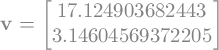

In [46]:
vvec_lambda = lambdify( (px,pz), 
                         Matrix([gmeq.rdotx_pxpz_eqn.rhs.subs({varphi_r(rvec):varphi_}),
                                   gmeq.rdotz_pxpz_eqn.rhs.subs({varphi_r(rvec):varphi_})]),
                           modules='sympy' )
vvec_ = vvec_lambda(px_,pz_)
Eq(rdotvec,vvec_)

In [47]:
pcovec_.dot(vvec_)

In [48]:
gstar_crit_ = (N(gstar_tanbeta_lambda(tanbeta_tanalpha_lambda(tanalpha_crit_,1),varphi_)))
(Eq(tan(alpha_crit), round(tanalpha_crit_,3)),
 ( det(gstar), 
   round((N(gstar_tanbeta_lambda(tanbeta_tanalpha_lambda(tanalpha_crit_*0.1,0),
                                 varphi_))).det(),3),
   round((N(gstar_tanbeta_lambda(tanbeta_tanalpha_lambda(tanalpha_crit_*0.5,0),
                                 varphi_))).det(),3),
   round((N(gstar_tanbeta_lambda(tanbeta_tanalpha_lambda(tanalpha_crit_*0.99,0),
                                 varphi_))).det(),3),
   round(gstar_crit_.det(),3),
   round((N(gstar_tanbeta_lambda(tanbeta_tanalpha_lambda(tanalpha_crit_*1.01,1),
                                 varphi_))).det(),3)))

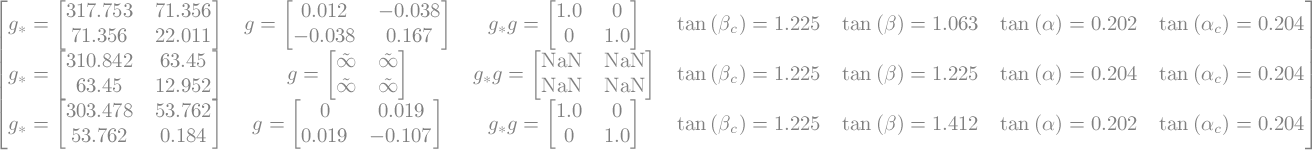

In [49]:
# tanalpha_crit_ = N(gmeq.tanalpha_crit_eqn.rhs.subs({eta:gmeq.eta}))
Matrix([
    (Eq(gstar, (N(gstar_tanbeta_lambda(tanbeta_tanalpha_lambda(tanalpha_,switch_),varphi_)))
                    .applyfunc(lambda x: round(x,3))), 
    Eq(g, (N(g_tanalpha_lambda(tanalpha_,varphi_,switch_)))
                    .applyfunc(lambda x: round(x,3))), 
    Eq(gstar*g, N((gstar_tanbeta_lambda(tanbeta_tanalpha_lambda(tanalpha_,switch_),varphi_))
                 *(g_tanalpha_lambda(tanalpha_,varphi_,switch_)))
                    .applyfunc(lambda x: round(x,3))), 
    Eq(tan(beta_crit), round(tanbeta_crit_,3)),
    Eq(tan(beta), round(tanbeta_tanalpha_lambda(tanalpha_,switch_),3)),
    Eq(tan(alpha),round(tanalpha_,3)), Eq(tan(alpha_crit),round(tanalpha_crit_,3)) )
 for tanalpha_,switch_ in zip([tanalpha_crit_*0.99, tanalpha_crit_, 
                               tanalpha_crit_*0.99],[0,0,1])])

## Eigenvectors, eigenvalues

In [50]:
g_tanalpha_ = (N(g_tanalpha_lambda(tanalpha_,varphi_,0)))
gstar_tanbeta_ = (N(gstar_tanbeta_lambda(tanbeta_tanalpha_lambda(tanalpha_,0),varphi_)))

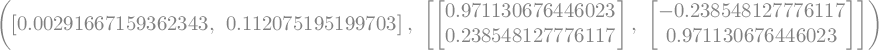

In [51]:
evs = g_tanalpha_.eigenvects()
get_eigenvalues(evs), get_eigenvectors(evs)

In [52]:
(get_eigentanangles(evs), Eq(tan(alpha),tanalpha_))

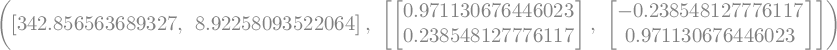

In [53]:
evs = gstar_tanbeta_.eigenvects()
get_eigenvalues(evs), get_eigenvectors(evs)

In [54]:
get_eigentanangles(evs), Eq(tan(beta),tanbeta_)

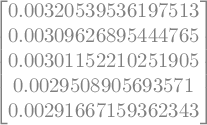

In [55]:
Matrix( [get_eigenvalues((N(g_tanalpha_lambda(tanalpha_*0.80,varphi_,0))).eigenvects())[0],
         get_eigenvalues((N(g_tanalpha_lambda(tanalpha_*0.85,varphi_,0))).eigenvects())[0],
         get_eigenvalues((N(g_tanalpha_lambda(tanalpha_*0.90,varphi_,0))).eigenvects())[0],
         get_eigenvalues((N(g_tanalpha_lambda(tanalpha_*0.95,varphi_,0))).eigenvects())[0],
         get_eigenvalues((N(g_tanalpha_lambda(tanalpha_*1.00,varphi_,0))).eigenvects())[0]] )

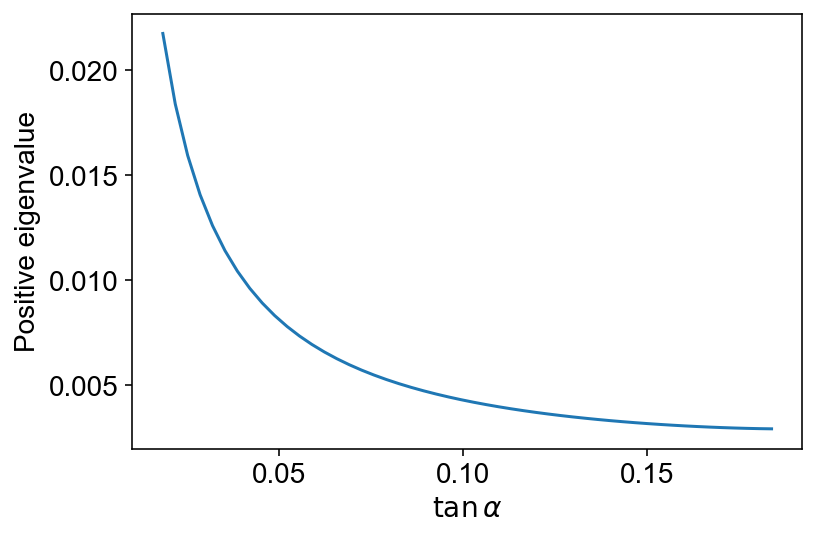

In [56]:
ta_array = np.linspace(0.1,1.0)*tanalpha_
ev_array = np.array( [float(get_eigenvalues((N(g_tanalpha_lambda(ta_,varphi_,0)))
                                            .eigenvects())[0]) for ta_ in ta_array] )
plt.plot(ta_array,ev_array)
plt.xlabel(r'$\tan\alpha$')
plt.ylabel('Positive eigenvalue');

## Arrays

In [57]:
H_lambda = lambdify( (px,pz),
                         gmeq.H_eqn.rhs.subs({varphi_r(rvec):varphi_}),
                         modules='sympy' )
round(H_lambda(px_,pz_),5)

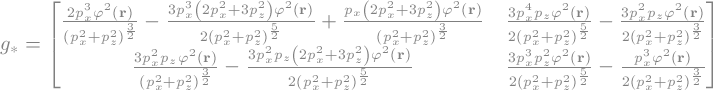

In [58]:
gmeq.gstar_varphi_pxpz_eqn

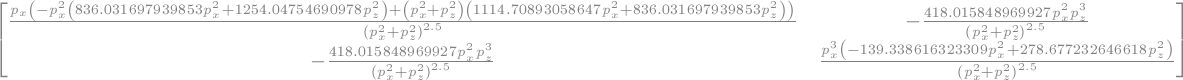

In [59]:
simplify(gmeq.gstar_varphi_pxpz_eqn.rhs.subs({varphi_r(rvec):varphi_})).n()

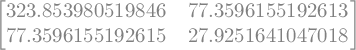

In [60]:
gstar_lambda = lambdify( (px,pz),
                         gmeq.gstar_varphi_pxpz_eqn.rhs.subs({varphi_r(rvec):varphi_}),
                         modules='sympy' )
gstar_lambda(px_,pz_)

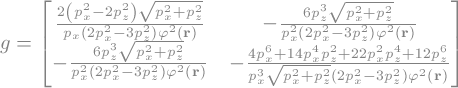

In [61]:
gmeq.g_varphi_pxpz_eqn

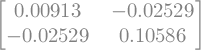

In [62]:
g_lambda = lambdify( (px,pz),
                     gmeq.g_varphi_pxpz_eqn.rhs.subs({varphi_r(rvec):varphi_}),
                     modules='sympy' )
g_lambda(px_,pz_).applyfunc(lambda x: round(x,5))

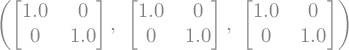

In [63]:
(
    (g_lambda(px_/1.3,pz_)*gstar_lambda(px_/1.3,pz_)).applyfunc(lambda x: round(x,5)),
    (g_lambda(px_*1.0,pz_)*gstar_lambda(px_*1.0,pz_)).applyfunc(lambda x: round(x,5)),
    (g_lambda(px_*1.3,pz_)*gstar_lambda(px_*1.3,pz_)).applyfunc(lambda x: round(x,5))
)

In [64]:
Eq(pcovec,pcovec_), Eq(pcovec,(g_lambda(px_,pz_)*vvec_).T)

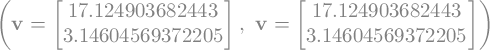

In [65]:
Eq(rdotvec,vvec_), Eq(rdotvec,(pcovec_*gstar_lambda(px_,pz_)).T)

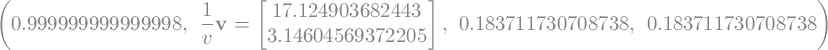

In [66]:
gvv_ = float((vvec_lambda(px_,pz_).T*g_lambda(px_,pz_)*vvec_lambda(px_,pz_))[0])
gvv_, Eq(rdotvec/rdot,vvec_/gvv_), float(vvec_[1]/vvec_[0]), tanalpha_

In [67]:
gstarpp_ = float((pcovec_lambda(px_,pz_)*gstar_lambda(px_,pz_)*pcovec_lambda(px_,pz_).T)[0])
gstarpp_

In [68]:
npx_ = float(px_)
if pr.model.eta == Rational(3,2):
    sfv = 1.2
    px_gvv_array = np.linspace(npx_/sfv,npx_*sfv)
    px_gstarpp_array = np.linspace(npx_/sfv,npx_*sfv)
else:
    sfv = 1.5
    px_gvv_array = np.linspace(npx_/sfv,npx_*sfv)
    px_gstarpp_array = np.linspace(npx_/sfv,npx_*sfv)
    
tanbeta_gvv_array = -px_gvv_array/pz_
tanbeta_gstarpp_array = -px_gstarpp_array/pz_
# These are not "correct" calculations of tan(alpha)...
tanalpha_gvv_array = np.array([tanalpha_tanbeta_lambda(tanbeta__) 
                               for tanbeta__ in tanbeta_gvv_array])

vx_array = np.array( [float((vvec_lambda(px__,pz_))[0]) for px__ in px_gvv_array] )
vz_array = np.array( [float((vvec_lambda(px__,pz_))[1]) for px__ in px_gvv_array] )
# ... but these *are* correct
tanalpha_vzvx_array = vz_array/vx_array
tanalpha_gvv_array,tanalpha_vzvx_array;
px_gstarpp_array

array([0.06397139, 0.06454582, 0.06512026, 0.0656947 , 0.06626913,
       0.06684357, 0.06741801, 0.06799244, 0.06856688, 0.06914132,
       0.06971575, 0.07029019, 0.07086463, 0.07143907, 0.0720135 ,
       0.07258794, 0.07316238, 0.07373681, 0.07431125, 0.07488569,
       0.07546012, 0.07603456, 0.076609  , 0.07718343, 0.07775787,
       0.07833231, 0.07890675, 0.07948118, 0.08005562, 0.08063006,
       0.08120449, 0.08177893, 0.08235337, 0.0829278 , 0.08350224,
       0.08407668, 0.08465111, 0.08522555, 0.08579999, 0.08637443,
       0.08694886, 0.0875233 , 0.08809774, 0.08867217, 0.08924661,
       0.08982105, 0.09039548, 0.09096992, 0.09154436, 0.09211879])

In [69]:
gvv_array = np.array( 
    [float((vvec_lambda(px__,pz_).T*g_lambda(px__,pz_)*vvec_lambda(px__,pz_))[0]) 
                         for px__ in px_gvv_array] )
vvec_list = [((pcovec_lambda(px__,pz_)*gstar_lambda(px__,pz_)))
                     for px__ in px_gvv_array]
vvec_array = np.stack([
    np.array([float(vvc[0]) for vvc in vvec_list]),
    np.array([float(vvc[1]) for vvc in vvec_list])
]).T
vvec_array[:,1]

array([2.18049037, 2.22227368, 2.26425438, 2.30642478, 2.34877723,
       2.39130416, 2.43399804, 2.4768514 , 2.51985684, 2.56300702,
       2.60629468, 2.6497126 , 2.69325369, 2.73691087, 2.7806772 ,
       2.82454578, 2.86850981, 2.91256256, 2.95669739, 3.00090777,
       3.04518723, 3.0895294 , 3.13392801, 3.17837685, 3.22286985,
       3.26740099, 3.31196438, 3.35655419, 3.40116473, 3.44579036,
       3.49042556, 3.53506491, 3.57970307, 3.62433482, 3.66895502,
       3.71355863, 3.75814071, 3.80269642, 3.847221  , 3.89170981,
       3.93615828, 3.98056196, 4.02491648, 4.06921758, 4.11346106,
       4.15764286, 4.20175898, 4.24580551, 4.28977866, 4.3336747 ])

In [70]:
H_array = np.array( 
    [float(H_lambda(px__,pz_)) for px__ in px_gstarpp_array] )
H_array

array([0.30728208, 0.31481092, 0.3224445 , 0.330183  , 0.33802658,
       0.34597539, 0.35402958, 0.3621893 , 0.37045466, 0.37882581,
       0.38730285, 0.3958859 , 0.40457506, 0.41337043, 0.4222721 ,
       0.43128015, 0.44039466, 0.44961571, 0.45894335, 0.46837767,
       0.4779187 , 0.48756649, 0.49732111, 0.50718257, 0.51715093,
       0.52722621, 0.53740843, 0.54769762, 0.55809379, 0.56859696,
       0.57920714, 0.58992433, 0.60074853, 0.61167974, 0.62271795,
       0.63386315, 0.64511534, 0.65647449, 0.66794058, 0.6795136 ,
       0.69119351, 0.70298029, 0.71487391, 0.72687434, 0.73898153,
       0.75119545, 0.76351606, 0.77594331, 0.78847716, 0.80111757])

In [71]:
pcovec_list = [((g_lambda(px__,pz_)*vvec_lambda(px__,pz_)))
                     for px__ in px_gvv_array]
pcovec_array = np.stack([
    np.array([float(pcvc[0]) for pcvc in pcovec_list]),
    np.array([float(pcvc[1]) for pcvc in pcovec_list])
]).T

In [72]:
gstarpp_array = np.array( 
    [float((pcovec_lambda(px__,pz_)*gstar_lambda(px__,pz_)*pcovec_lambda(px__,pz_).T)[0]) 
     for px__ in px_gstarpp_array] )
gstarpp_array

array([0.61456415, 0.62962183, 0.644889  , 0.660366  , 0.67605315,
       0.69195078, 0.70805916, 0.72437859, 0.74090933, 0.75765162,
       0.77460571, 0.7917718 , 0.80915012, 0.82674086, 0.84454419,
       0.86256029, 0.88078932, 0.89923141, 0.91788671, 0.93675533,
       0.95583739, 0.97513299, 0.99464222, 1.01436515, 1.03430186,
       1.05445241, 1.07481686, 1.09539524, 1.11618758, 1.13719392,
       1.15841428, 1.17984865, 1.20149705, 1.22335947, 1.2454359 ,
       1.26772631, 1.29023068, 1.31294898, 1.33588117, 1.3590272 ,
       1.38238702, 1.40596059, 1.42974783, 1.45374867, 1.47796305,
       1.50239089, 1.52703211, 1.55188662, 1.57695433, 1.60223514])

In [73]:
(
    pcovec_lambda(px_gvv_array[0],pz_)*vvec_lambda(px_gvv_array[0],pz_),
    pcovec_lambda(px_,pz_)*vvec_lambda(px_,pz_),
    pcovec_lambda(px_gvv_array[-1],pz_)*vvec_lambda(px_gvv_array[-1],pz_),    
)

In [74]:
(
    vvec_lambda(px_gvv_array[0],pz_)[0], 
    (pcovec_lambda(px_gvv_array[0],pz_)*gstar_lambda(px_gvv_array[0],pz_))[0], 
    vvec_array[0,0], vx_array[0]
)

In [75]:
beta_array = np.linspace(0,90)
alpha_array = np.rad2deg(np.arctan(tanalpha_tanbeta_lambda(np.tan(np.deg2rad(beta_array)))))

# Plots

In [76]:
gr = AlphaBeta()

### Anisotropy

Creating plot: metricspace_sinbeta_ramp_eta1p5_ratio0p5_alpha_beta


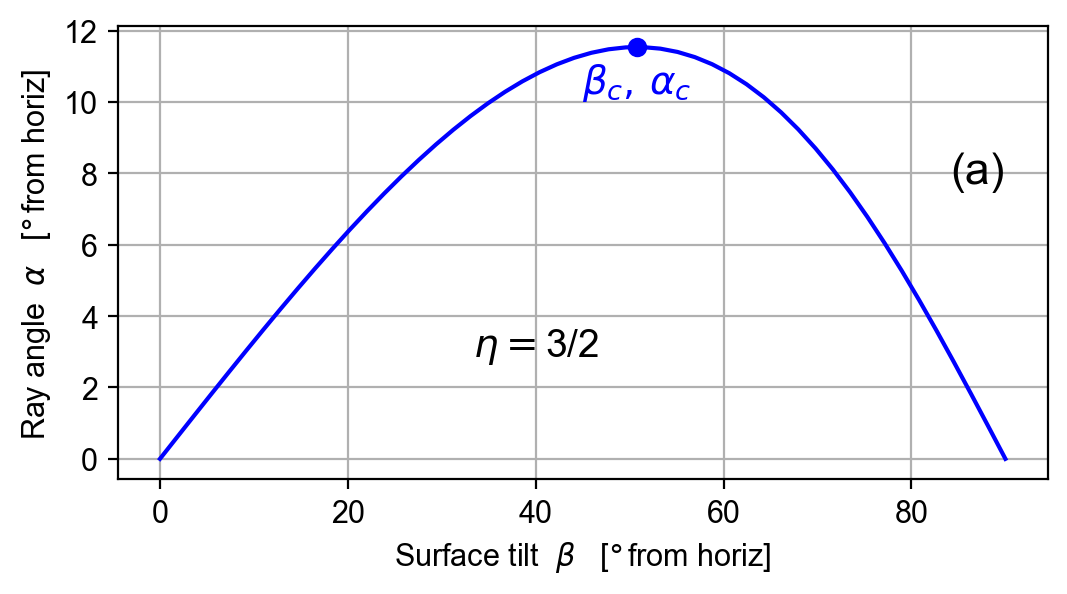

In [77]:
gr.alpha_beta(gmeq, job_name+'_alpha_beta', 
              alpha_array, beta_array, tanalpha_crit_, tanbeta_crit_, fig_size=(6,3))

Creating plot: metricspace_sinbeta_ramp_eta1p5_ratio0p5_beta_anisotropy


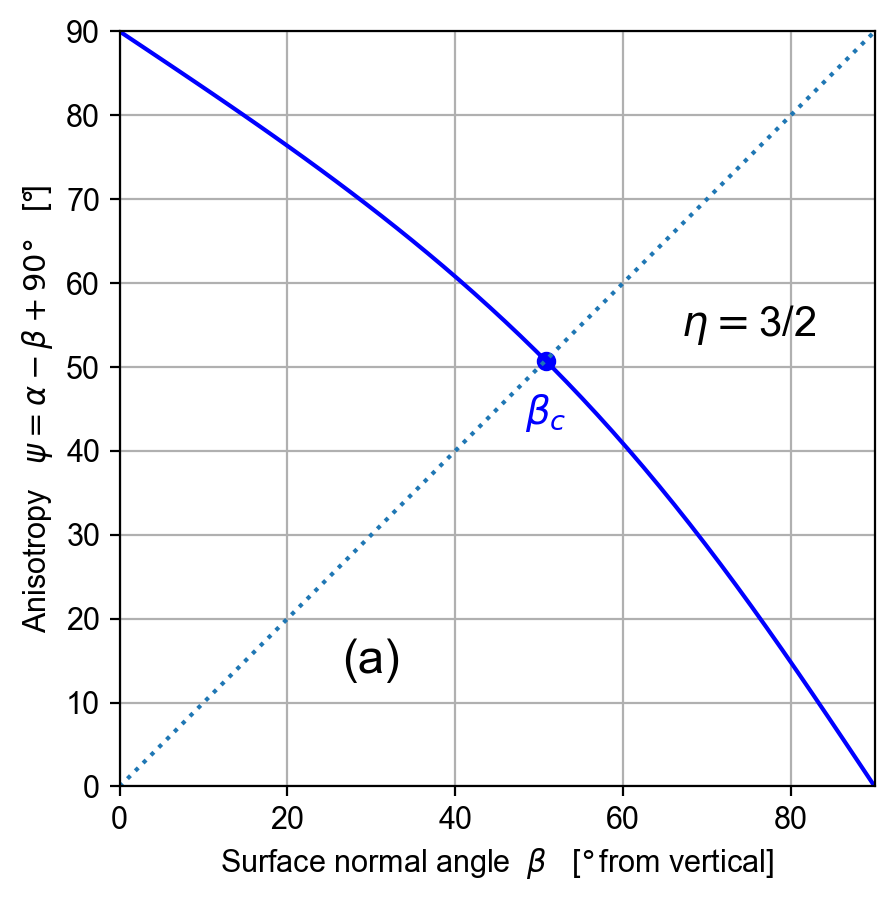

In [78]:
gr.beta_anisotropy(gmeq, job_name+'_beta_anisotropy', 
                   alpha_array, beta_array, tanalpha_crit_, tanbeta_crit_, fig_size=(6,5))

Creating plot: metricspace_sinbeta_ramp_eta1p5_ratio0p5_alpha_anisotropy


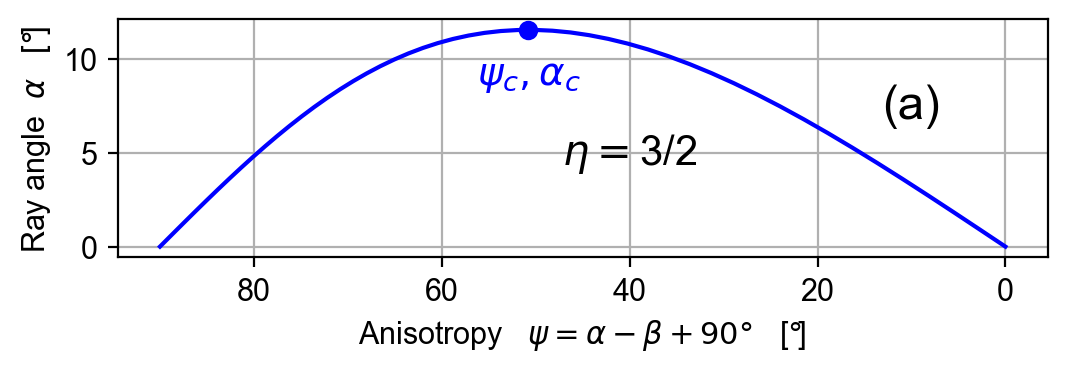

In [79]:
gr.alpha_anisotropy(gmeq, job_name+'_alpha_anisotropy', 
                    alpha_array, beta_array, tanalpha_crit_, tanbeta_crit_, 
                    fig_size=(6,5))

Creating plot: metricspace_sinbeta_ramp_eta1p5_ratio0p5_alpha_image


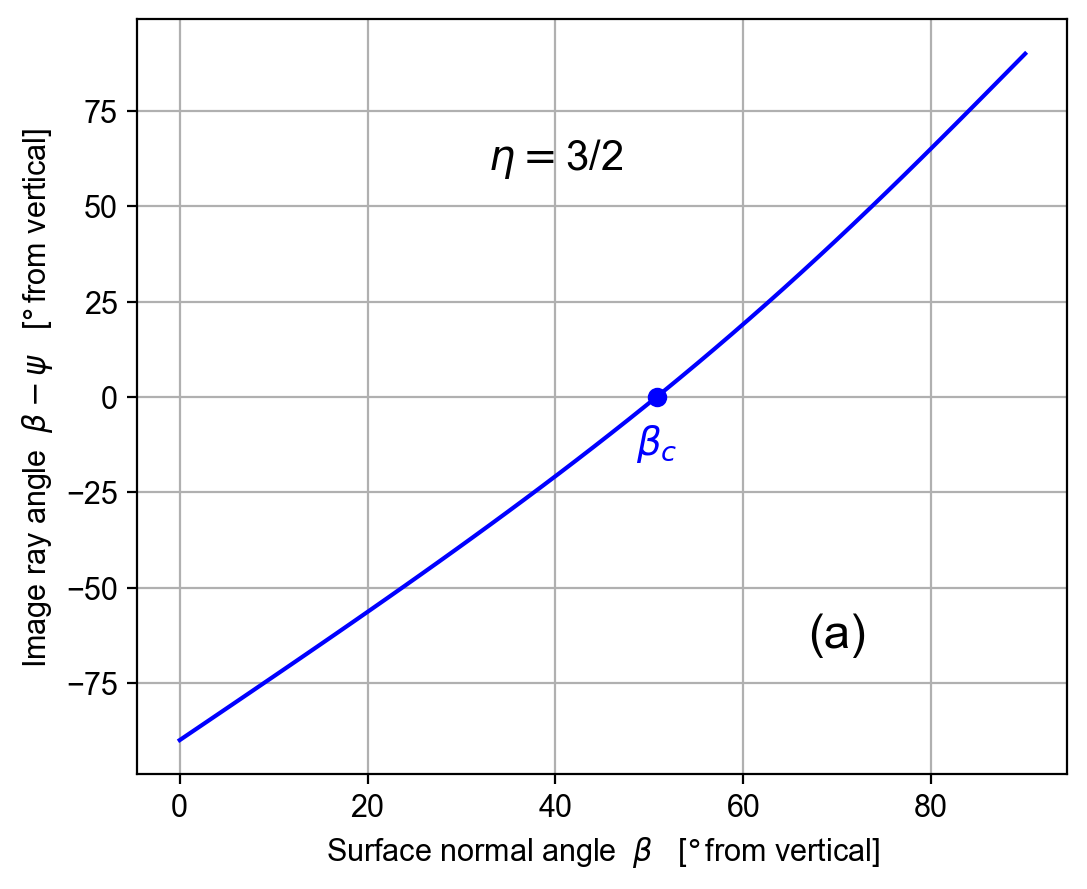

In [80]:
gr.alpha_image(gmeq, job_name+'_alpha_image', 
               alpha_array, beta_array, tanalpha_crit_, tanbeta_crit_, fig_size=(6,5))

### Misc

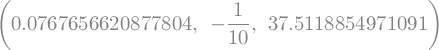

In [81]:
px_,pz_, deg(atan(-px_/pz_)).n()

Creating plot: metricspace_sinbeta_ramp_eta1p5_ratio0p5_pdotv_px


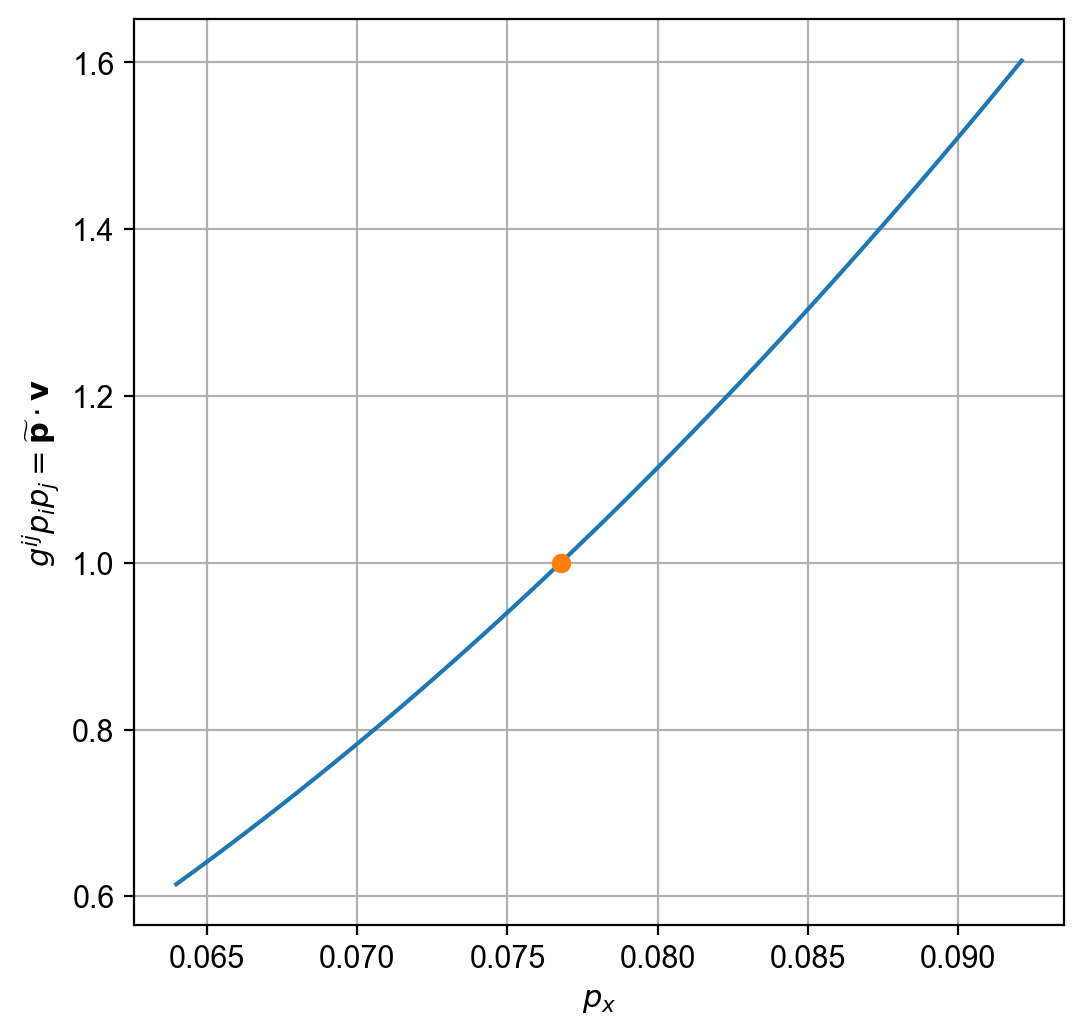

In [82]:
fig = gr.create_figure(job_name+'_pdotv_px', fig_size=(6,6))
plt.plot(px_gstarpp_array, gstarpp_array-H_array*0)
plt.plot(px_, gstarpp_, 'o')
plt.grid('on')
plt.ylabel(r'$g^{ij} p_i p_j = \mathbf{\widetilde{p}}\cdot\mathbf{v}$')
plt.xlabel(r'$p_x$');

Creating plot: metricspace_sinbeta_ramp_eta1p5_ratio0p5_pdotv_tanbeta


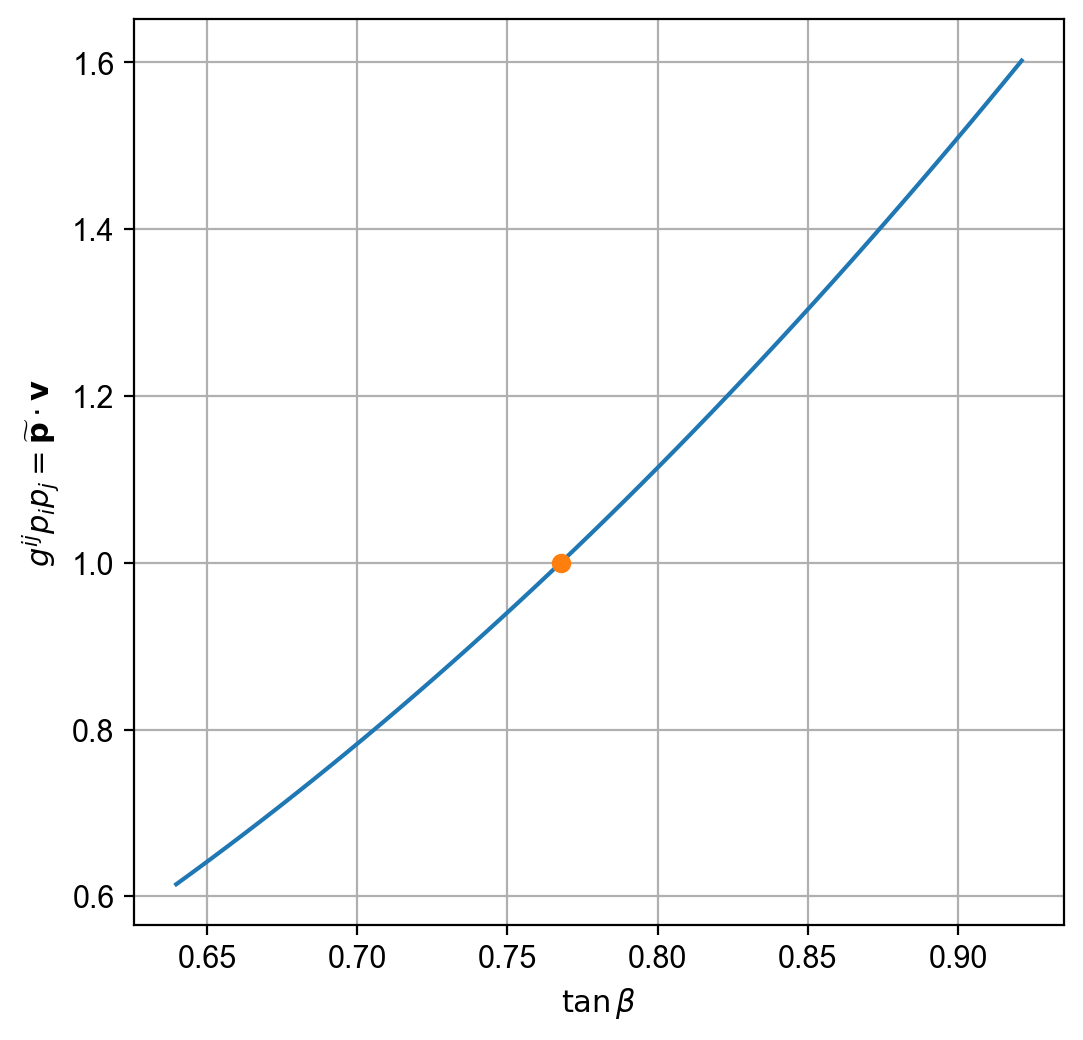

In [83]:
fig = gr.create_figure(job_name+'_pdotv_tanbeta', fig_size=(6,6))
plt.plot(tanbeta_gstarpp_array, gstarpp_array)
plt.plot(-px_/pz_, gstarpp_, 'o')
plt.grid('on')
plt.ylabel(r'$g^{ij} p_i p_j = \mathbf{\widetilde{p}}\cdot\mathbf{v}$')
plt.xlabel(r'$\tan\beta$');

Creating plot: metricspace_sinbeta_ramp_eta1p5_ratio0p5_pdotv_modv


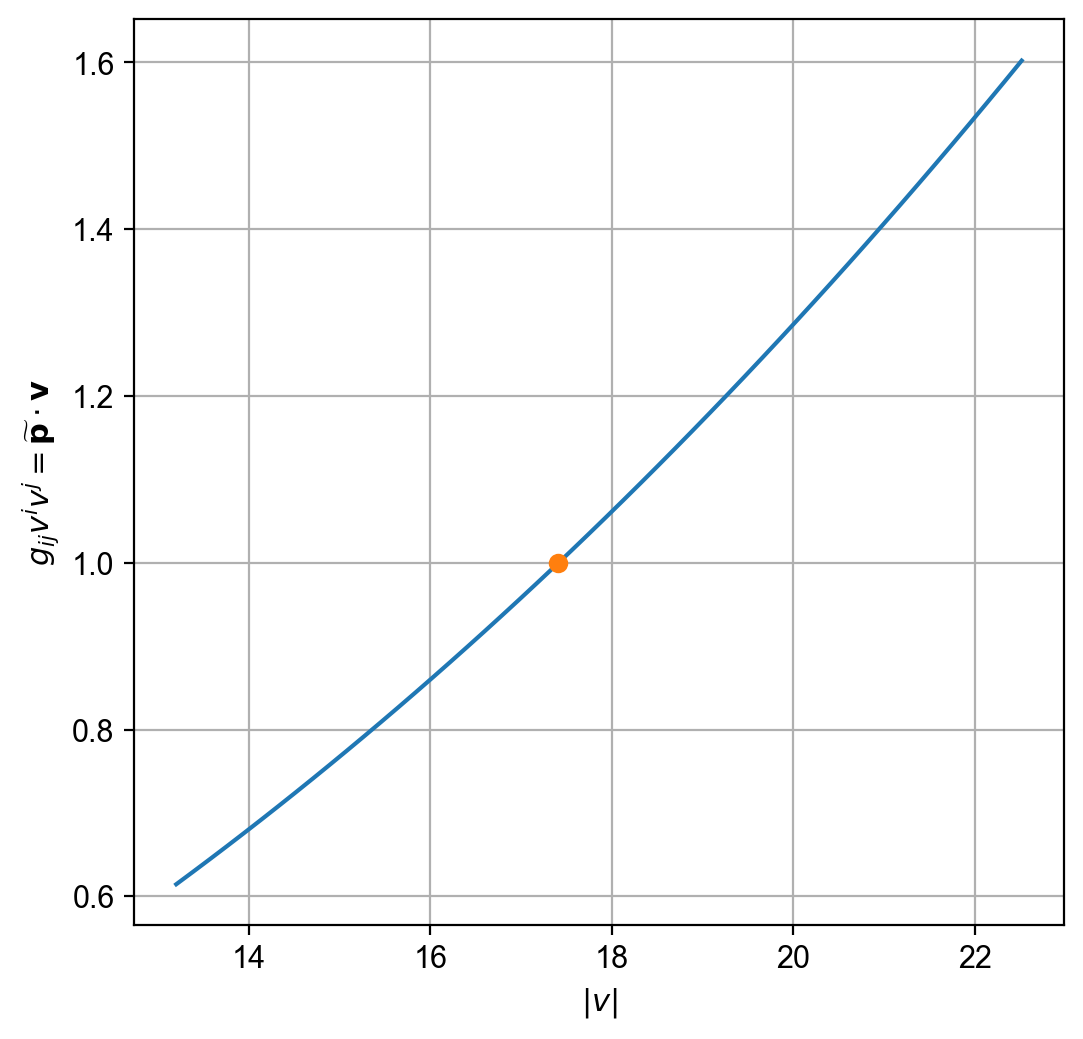

In [84]:
fig = gr.create_figure(job_name+'_pdotv_modv', fig_size=(6,6))
plt.plot(np.sqrt(vx_array**2+vz_array**2), gvv_array)
vvec_ = vvec_lambda(px_,pz_)
plt.plot(np.sqrt(float(vvec_[0])**2+float(vvec_[1])**2), gvv_, 'o')
plt.grid('on')
plt.ylabel(r'$g_{ij} v^i v^j = \mathbf{\widetilde{p}}\cdot\mathbf{v}$')
plt.xlabel(r'$|v|$');

Creating plot: metricspace_sinbeta_ramp_eta1p5_ratio0p5_pdotv_tanalpha


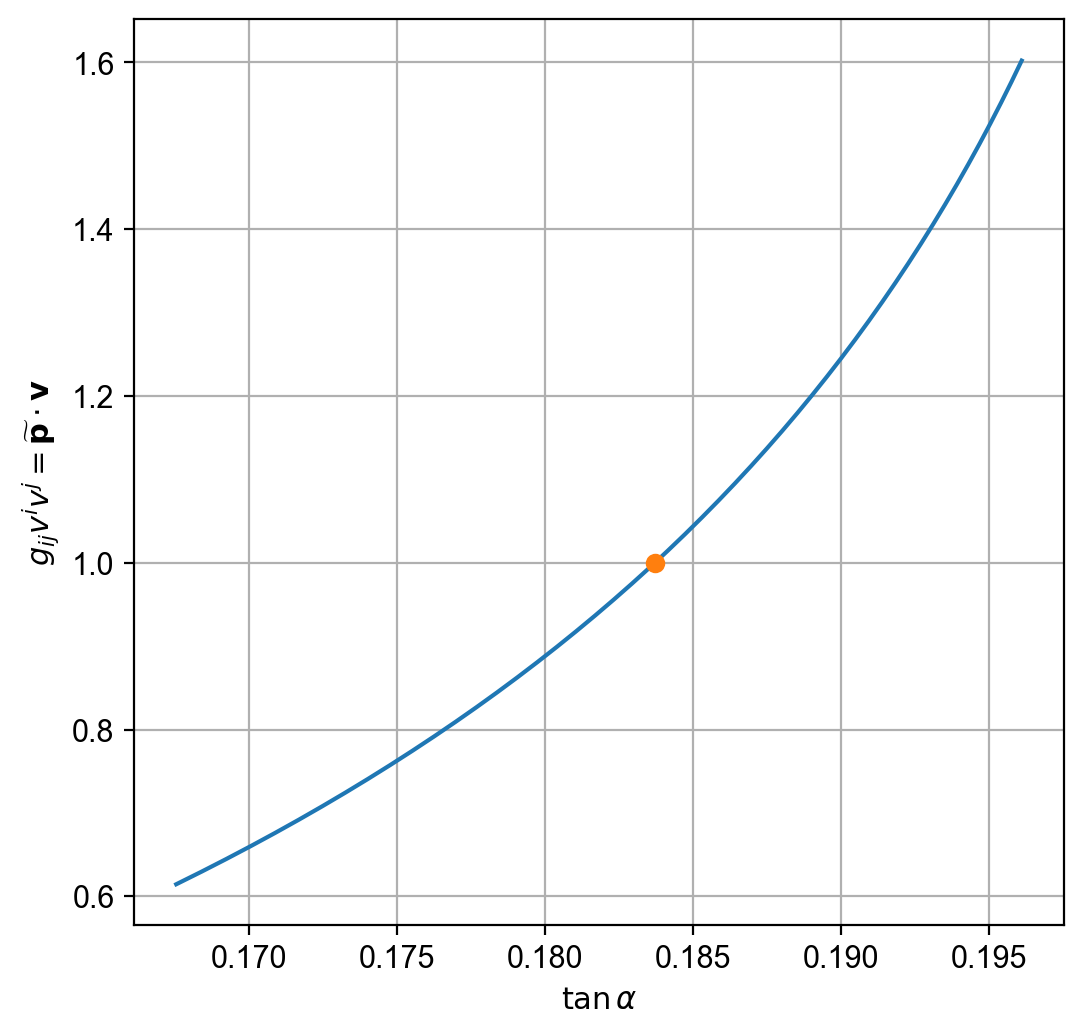

In [85]:
fig = gr.create_figure(job_name+'_pdotv_tanalpha', fig_size=(6,6))
plt.plot(tanalpha_vzvx_array, gvv_array)
plt.plot(tanalpha_, gvv_, 'o')
plt.grid('on')
plt.ylabel(r'$g_{ij} v^i v^j = \mathbf{\widetilde{p}}\cdot\mathbf{v}$')
plt.xlabel(r'$\tan\alpha$');

# Save

Export the graphs as PNG and/or PDF image files.

In [86]:
plots_dir = create_directories(pr.save.figs_path, pr.job.group_name)
export_plots( gr.fdict, plots_dir, pr.save.figs_format, suffix='' )

Writing to dir: "/Users/colinstark/Projects/GME/Plots/Theory"
Exported "metricspace_sinbeta_ramp_eta1p5_ratio0p5_alpha_beta.png"
Exported "metricspace_sinbeta_ramp_eta1p5_ratio0p5_beta_anisotropy.png"
Exported "metricspace_sinbeta_ramp_eta1p5_ratio0p5_alpha_anisotropy.png"
Exported "metricspace_sinbeta_ramp_eta1p5_ratio0p5_alpha_image.png"
Exported "metricspace_sinbeta_ramp_eta1p5_ratio0p5_pdotv_px.png"
Exported "metricspace_sinbeta_ramp_eta1p5_ratio0p5_pdotv_tanbeta.png"
Exported "metricspace_sinbeta_ramp_eta1p5_ratio0p5_pdotv_modv.png"
Exported "metricspace_sinbeta_ramp_eta1p5_ratio0p5_pdotv_tanalpha.png"
